# 05 - Taming Text

## Deadline
Thursday December 15, 2016 at 11:59PM

## Important Notes
* Make sure you push on GitHub your Notebook with all the cells already evaluated
* Don't forget to add a textual description of your thought process, the assumptions you made, and the solution
you plan to implement!
* Please write all your comments in English, and use meaningful variable names in your code

## Background
In this homework you will explore a relatively large corpus of emails released in public during the
[Hillary Clinton email controversy](https://en.wikipedia.org/wiki/Hillary_Clinton_email_controversy).
You can find the corpus in the `hillary-clinton-emails` directory of this repository, while more detailed information 
about the [schema is available here](https://www.kaggle.com/kaggle/hillary-clinton-emails).

## Assignment
1. Generate a word cloud based on the raw corpus -- I recommend you to use the [Python word_cloud library](https://github.com/amueller/word_cloud).
With the help of `nltk` (already available in your Anaconda environment), implement a standard text pre-processing 
pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and
cons (if any) of the two word clouds you generated.

2. Find all the mentions of world countries in the whole corpus, using the `pycountry` utility (*HINT*: remember that
there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.)
Perform sentiment analysis on every email message using the demo methods in the `nltk.sentiment.util` module. Aggregate 
the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level)
that summarizes the perception of the different countries. Repeat the aggregation + plotting steps using different demo
methods from the sentiment analysis module -- can you find substantial differences?

3. Using the `models.ldamodel` module from the [gensim library](https://radimrehurek.com/gensim/index.html), run topic
modeling over the corpus. Explore different numbers of topics (varying from 5 to 50), and settle for the parameter which
returns topics that you consider to be meaningful at first sight.

4. *BONUS*: build the communication graph (unweighted and undirected) among the different email senders and recipients
using the `NetworkX` library. Find communities in this graph with `community.best_partition(G)` method from the 
[community detection module](http://perso.crans.org/aynaud/communities/index.html). Print the most frequent 20 words used
by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA?
Can you identify clear discussion topics for each community? Discuss briefly the obtained results.


# 0. Prelude

In [2]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
%matplotlib inline

# 1. Word cloud
Generate a word cloud based on the raw corpus -- I recommend you to use the [Python word_cloud library](https://github.com/amueller/word_cloud).
With the help of `nltk` (already available in your Anaconda environment), implement a standard text pre-processing 
pipeline (e.g., tokenization, stopword removal, stemming, etc.) and generate a new word cloud. Discuss briefly the pros and
cons (if any) of the two word clouds you generated.

In [119]:
filename='hillary-clinton-emails/Emails.csv'
df = pd.read_csv(filename)
df.sample(5)

,Id,DocNumber,MetadataSubject,MetadataTo,MetadataFrom,SenderPersonId,MetadataDateSent,MetadataDateReleased,MetadataPdfLink,MetadataCaseNumber,...,ExtractedTo,ExtractedFrom,ExtractedCc,ExtractedDateSent,ExtractedCaseNumber,ExtractedDocNumber,ExtractedDateReleased,ExtractedReleaseInPartOrFull,ExtractedBodyText,RawText
6921,6922,C05773461,NaN,H,"Abedin, Huma",81.0,2010-12-21T05:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0114/DOC_0C0...,F-2014-20439,...,H; hanIeymr@state.gov,Huma Abedin <Huma@clintonemail.com >,NaN,"Tuesday, December 21, 2010 9:24 PM",F-2014-20439,C05773461,08/31/2015,RELEASE IN PART,Cannot do 8:30am.,UNCLASSIFIED U.S. Department of State Case No....
3225,3226,C05765662,CONGRATS ON USAID,H,"Mills, Cheryl D",32.0,2009-11-10T05:00:00+00:00,2015-07-31T04:00:00+00:00,DOCUMENTS/HRCEmail_JulyWeb/Web_047/DOC_0C05765...,F-2014-20439,...,NaN,NaN,NaN,NaN,F-2014-20439,C05765662,07/31/2015,RELEASE IN PART,"Mills, Cheryl D <MillsCD@state.gov>\nTuesday, ...",UNCLASSIFIED U.S. Department of State Case No....
4015,4016,C05767244,SHUTTLE,H,"Abedin, Huma",81.0,2010-02-18T05:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0065/DOC_0C0...,F-2014-20439,...,H; 'ValmoroU@state.gov',Huma Abedin <,NaN,"Thursday, February 18, 2010 7:55 AM",F-2014-20439,C05767244,08/31/2015,RELEASE IN PART,Yes we can do that this afternoon.,UNCLASSIFIED U.S. Department of State Case No....
5564,5565,C05770420,(AP) HAITI PROSECUTORS URGE PRISON FOR US MIS...,H,"Abedin, Huma",81.0,2010-05-13T04:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0079/DOC_0C0...,F-2014-20439,...,H,"Abedin, Huma <AbedinH@state.gov>",SES-O_Shift-III,"Thursday, May 13, 2010 5:35 PM",F-2014-20439,C05770420,08/31/2015,RELEASE IN FULL,NaN,UNCLASSIFIED U.S. Department of State Case No....
4860,4861,C05769080,LEW CALL TO PALAU PRES. TODAY,"Sullivan, Jake","Farrow, Jeffrey L",93.0,2010-01-20T05:00:00+00:00,2015-08-31T04:00:00+00:00,DOCUMENTS/HRCEmail_August_Web/IPS-0059/DOC_0C0...,F-2014-20439,...,Jai:e Sullivan,Jeffrey L Farrow,Jake Suliivan,"Wednesday, January 20, 2010 3:17 PM",F-2014-20439,C05769080,08/31/2015,RELEASE IN PART,"importance: High\nJake, Jack is to call Palau'...",UNCLASSIFIED U.S. Department of State Case No....


Let's extract the whole corpus by concatenating the subject and body of every e-mail:

In [126]:
def extract_corpus(df):
    raw_body    = df['ExtractedBodyText'].dropna().reset_index()
    raw_subject = df['ExtractedSubject'].dropna().reset_index()
    return ' '.join(raw_subject['ExtractedSubject']) + ' '.join(raw_body['ExtractedBodyText'])

raw_corpus = extract_corpus(df)

Define a helper function to generate a WordCloud:

In [135]:
def gen_wordcloud(text):
    wc = WordCloud(
        background_color='white',
        max_font_size=50
    )
    
    return wc.generate(text)

Define a helper function to plot a WordCloud:

In [136]:
from wordcloud import WordCloud

def plot_wordcloud(cloud):
    plt.figure(figsize=(16, 12))
    plt.imshow(cloud)
    plt.axis("off")
    plt.show()

### 1.1 No pre-processing

Here, we plot a WorldClout of the raw corpus, before any type of pre-processing (such as stemming, etc.):

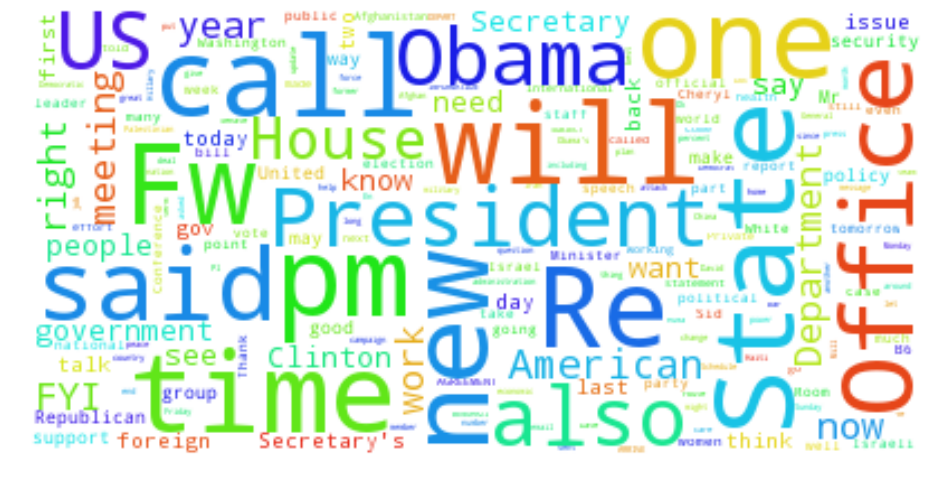

In [137]:
wordcloud = gen_wordcloud(raw_corpus)
plot_wordcloud(wordcloud)

### 1.2 Standard stemming

For this part we will use `ntlk`'s built-in Snowball stemmer and tokenizer, plus a list of custom stopwords.

In [152]:
from nltk.stem.snowball import SnowballStemmer

local_stopwords = [
    'fyi', 'will', 'call', 'said', 'time', 'want', 'know', 'pm', 'am', 
    'also', 'call', 'know', 'would', 'get', 'time', 'work', 'like', 'today',
    'see', 'morning', 'also', 'back', 'tomorrow', 'meeting', 'think', 'good',
    'want', 'could', 'working', 'well', 'pls', 're', 'fw', 'new'
]

stemmer = SnowballStemmer('english', ignore_stopwords=True)

Let's define a helper function to tokenize and stem some text:

In [153]:
import re

def tokenize_and_stem(text):
    
    # First tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    
    # Filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    filtered_tokens = [token for token in tokens if re.search('^[a-zA-Z]+$', token)]

    # Stem the resulting tokens, filtering out words present in our local stopwords list
    stems = [stemmer.stem(token) for token in filtered_tokens if token not in local_stopwords]
    
    # Once again, filter out words present in our local stopwords list
    return [stem for stem in stems if stem not in local_stopwords]

Tokenize the whole corpus:

In [154]:
tokenized = tokenize_and_stem(raw_corpus)

Join the list of tokens by space, to get a single resulting string:

In [155]:
flat_tok = ' '.join(tokenized)

Generate and plot a WordCloud of that resulting string:

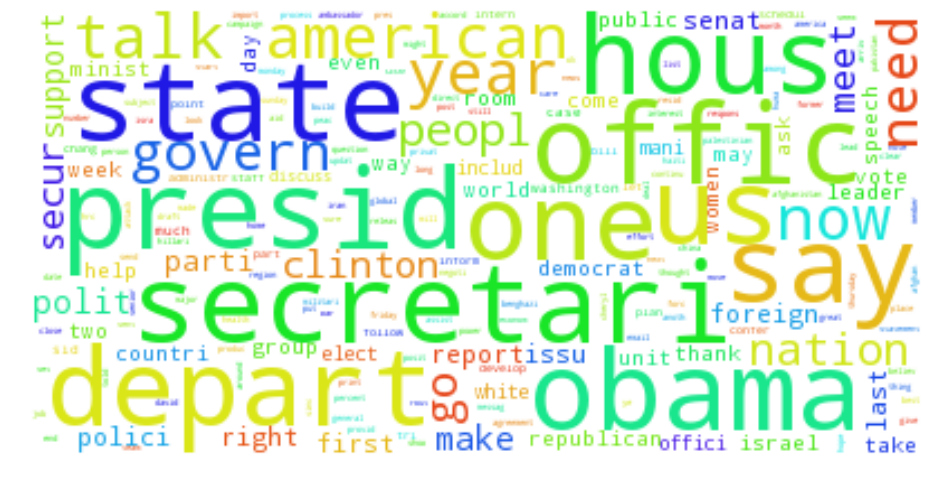

In [156]:
wordcloud_processed = gen_wordcloud(flat_tok)
plot_wordcloud(wordcloud_processed)

# 2. Sentiment analysis

* Find all the mentions of world countries in the whole corpus, using the `pycountry` utility (*HINT*: remember that
there will be different surface forms for the same country in the text, e.g., Switzerland, switzerland, CH, etc.)
* Perform sentiment analysis on every email message using the demo methods in the `nltk.sentiment.util` module. 
* Aggregate the polarity information of all the emails by country, and plot a histogram (ordered and colored by polarity level) that summarizes the perception of the different countries.
* Repeat the aggregation + plotting steps using different demo methods from the sentiment analysis module -- can you find substantial differences?

### Extract countries and perform sentiment analysis

Please see [extract_countries_parallel.py](https://github.com/romac/ADAHomeworks/blob/master/05%20-%20Taming%20Text/extract_countries_parallel.py) for the code we used to process the whole corpus of e-mails in parallel and generate the following two pickled data structures:

In [143]:
import pickle

sentiments_data_nocodes = pickle.load(open('countries_sentiments_vader_nocodes.p', 'rb'))
sentiments_data_codes   = pickle.load(open('countries_sentiments_vader_codes.p', 'rb'))

### Aggregate the polarity information of all the emails by country,

In [106]:
def aggregate_by_country(data, threshold):
    res = {}

    for key in data:
        sents = data[key]['sentiments']
        count = data[key]['count']

        if count < threshold:
            continue

        res[key] = {
            'sentiment': sum(sents) / float(len(sents)),
            'count': count
        }

    countries_df = pd.DataFrame.from_dict(res, orient='index')
    countries_df = countries_df.sort_values(by='sentiment', axis=0)
    
    return countries_df

In [145]:
countries_df_nocodes = aggregate_by_country(sentiments_data_nocodes, 25)
countries_df_codes = aggregate_by_country(sentiments_data_codes, 500)

### Plot a histogram that summarizes the perception of the different countries

In [146]:
def plot_countries(countries_df):

    # Credits to Stack Overflow :
    # http://stackoverflow.com/questions/31313606/pyplot-matplotlib-bar-chart-with-fill-color-depending-on-value
    from matplotlib import cm

    plt.figure(figsize=(18, 8), dpi=80)

    # Set up colors : red to green
    y = np.array(countries_df['sentiment'])
    colors = cm.RdYlGn((y / float(max(y))))
    plot = plt.scatter(y, y, c=y, cmap = 'RdYlGn')
    plt.clf()
    clb = plt.colorbar(plot)
    clb.ax.set_title("Sentiment")

    # Display bar plot : country frequency vs. country name, with color indicating polarity score
    plt.bar(range(countries_df.shape[0]), countries_df['count'], align='center', tick_label=countries_df.index, color=colors)
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Country")
    plt.ylabel("Frequency")
    plt.show()

#### When using only the country names to match countries in the corpus

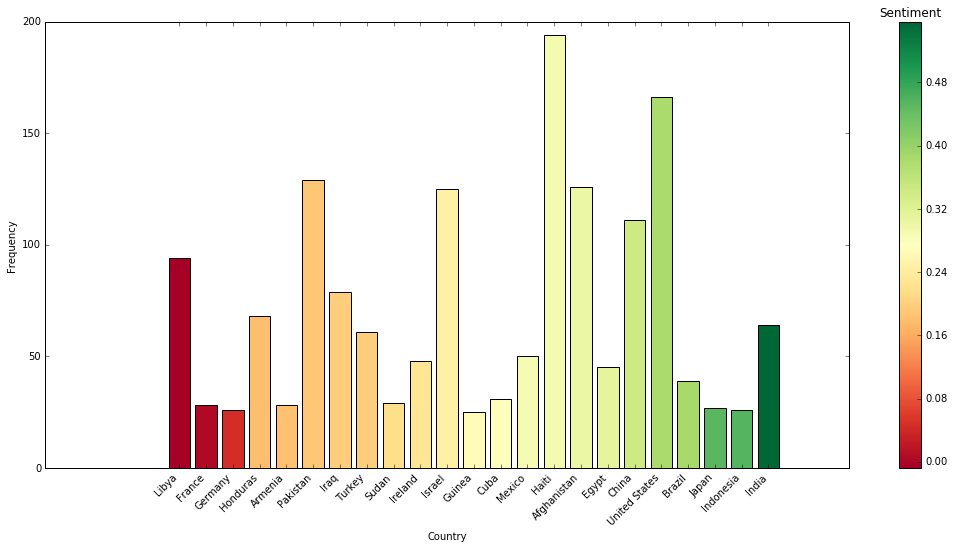

In [148]:
plot_countries(countries_df_nocodes)

#### When using the country names and short codes to match countries in the corpus

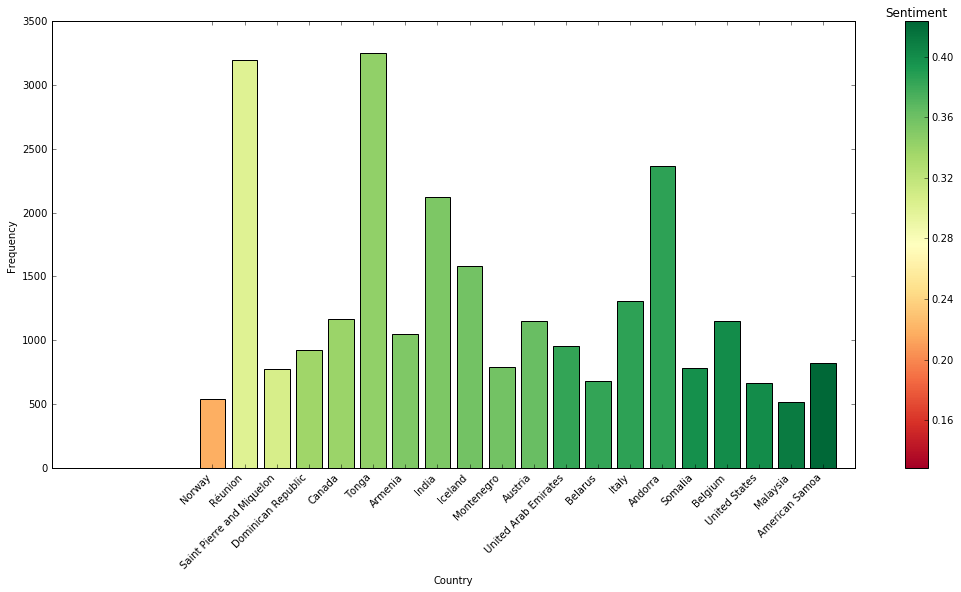

In [110]:
plot_countries(countries_df_codes)

# 3. Topic modelling 
### 3.1 Sci-kit learn version

Using the `models.ldamodel` module from the [gensim library](https://radimrehurek.com/gensim/index.html), run topic
modeling over the corpus. Explore different numbers of topics (varying from 5 to 50), and settle for the parameter which
returns topics that you consider to be meaningful at first sight.

In [95]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.feature_extraction import text
from sklearn.externals import joblib

In [92]:
def fit_tfidf(emails):
    tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                       min_df=0.2, stop_words=text.ENGLISH_STOP_WORDS,
                                       use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

    tfidf_matrix = tfidf_vectorizer.fit_transform(emails)
    terms = tfidf_vectorizer.get_feature_names()
    return (terms, tfidf_matrix, tfidf_vectorizer)

In [96]:
def fit_tf(articles):
    tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                                    max_features=1000,
                                    stop_words=text.ENGLISH_STOP_WORDS)
    tf_matrix = tf_vectorizer.fit_transform(articles)
    terms = tf_vectorizer.get_feature_names()
    return (terms, tf_matrix, tf_vectorizer)

In [117]:
def run_lda(tf_matrix, tf_vectorizer):
    lda = LatentDirichletAllocation(n_topics=n_topics,
                                    max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0)

    lda.fit(tf_matrix)
    return lda

In [127]:
def print_top_words(model, feature_names, n_top_words=20):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join(['\n + ' + str(topic[i]) + '*' + str(feature_names[i])
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [91]:
print(type(raw_corpus))

<class 'str'>


In [97]:
tfidf_terms, tfidf_matrix, tfidf_vectorizer = fit_tf(raw['ExtractedBodyText'])

In [98]:
joblib.dump(tfidf_matrix, 'tfidf_matrix.pkl')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(tfidf_terms, 'tfidf_terms.pkl')

['tfidf_terms.pkl']

In [99]:
n_topics = 10; n_top_words = 20

In [118]:
lda = run_lda(tfidf_matrix, tfidf_vectorizer)

In [158]:
joblib.dump(lda, 'sklearn_lda_model.pkl')

['sklearn_lda_model.pkl',
 'sklearn_lda_model.pkl_01.npy',
 'sklearn_lda_model.pkl_02.npy',
 'sklearn_lda_model.pkl_03.npy']

In [128]:
print_top_words(lda, tfidf_terms, n_top_words)

Topic #0:

 + 256.296004302*pls 
 + 238.633932215*print 
 + 178.356853464*thank 
 + 153.938180524*koch 
 + 127.77623719*pis 
 + 86.6047152067*add 
 + 70.4246712501*fax 
 + 69.7582445507*secure 
 + 68.5047329801*speak 
 + 39.8028888905*coming 
 + 39.4749971608*sure 
 + 37.5250937124*sent 
 + 28.1236385637*soon 
 + 19.2837182355*numbers 
 + 15.3064306839*hear 
 + 10.8432831735*version 
 + 8.60784517733*discuss 
 + 8.03640413908*hours 
 + 8.02951418101*hillary 
 + 6.3255957563*meet
Topic #1:

 + 656.982975215*know 
 + 558.153659417*just 
 + 480.041426977*think 
 + 435.22715219*want 
 + 425.617145753*work 
 + 413.000579285*tomorrow 
 + 400.337322627*good 
 + 394.352757896*like 
 + 385.753198842*let 
 + 377.762436724*time 
 + 371.788236429*today 
 + 339.525340384*talk 
 + 311.485375768*ll 
 + 303.332387665*ok 
 + 291.038663525*going 
 + 286.980379793*don 
 + 256.240536066*make 
 + 227.562769691*need 
 + 227.513572332*morning 
 + 226.713983979*ve
Topic #2:

 + 682.589549869*fyi 
 + 318.40856

### 3.2 gensim version

In [153]:
from gensim import corpora, models

# This is kind of the same as the earlier tokenize_and_stem 
# but for some reason I had some issues with it (BoW wasn't accepting my tokens :()
# Source :
# https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html
#

for mail in raw['ExtractedBodyText']:
    tokens = tokenizer.tokenize(mail)
    stopped_tokens = [tok for tok in tokens if not tok in text.ENGLISH_STOP_WORDS] # BAD
    stemmed_tokens = [stemmer.stem(tok) for tok in stopped_tokens]
    texts.append(stemmed_tokens)

# Create dictionary
dictionary = corpora.Dictionary(texts)
# Bag of Words
corpus = [dictionary.doc2bow(text) for text in texts]
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=20, id2word = dictionary, passes=20)

In [155]:
print(ldamodel.print_topics(num_topics=20, num_words=10))

[(0, '0.019*"build" + 0.019*"offic" + 0.014*"senat" + 0.013*"number" + 0.011*"kennedi" + 0.009*"ill" + 0.008*"limit" + 0.007*"grid" + 0.007*"cell" + 0.007*"church"'), (1, '0.065*"pm" + 0.038*"s" + 0.036*"secretari" + 0.035*"offic" + 0.031*"30" + 0.028*"00" + 0.027*"depart" + 0.022*"8" + 0.022*"w" + 0.020*"10"'), (2, '0.056*"fyi" + 0.050*"no" + 0.043*"state" + 0.033*"to" + 0.030*"2015" + 0.021*"benghazi" + 0.020*"subject" + 0.020*"doc" + 0.019*"inform" + 0.018*"f"'), (3, '0.021*"i" + 0.016*"haiti" + 0.014*"work" + 0.013*"un" + 0.009*"women" + 0.008*"peopl" + 0.008*"haitian" + 0.008*"plan" + 0.007*"need" + 0.007*"issu"'), (4, '0.097*"i" + 0.014*"s" + 0.013*"work" + 0.013*"m" + 0.012*"know" + 0.011*"want" + 0.011*"we" + 0.010*"w" + 0.010*"just" + 0.010*"tomorrow"'), (5, '0.035*"ok" + 0.023*"pls" + 0.021*"print" + 0.020*"will" + 0.019*"i" + 0.018*"email" + 0.017*"can" + 0.017*"sent" + 0.016*"thx" + 0.016*"call"'), (6, '0.024*"senat" + 0.018*"koch" + 0.014*"said" + 0.012*"boehner" + 0.012*"

In [157]:
joblib.dump(ldamodel, 'gensim_lda_model.pkl')

['gensim_lda_model.pkl',
 'gensim_lda_model.pkl_01.npy',
 'gensim_lda_model.pkl_02.npy',
 'gensim_lda_model.pkl_03.npy',
 'gensim_lda_model.pkl_04.npy',
 'gensim_lda_model.pkl_05.npy',
 'gensim_lda_model.pkl_06.npy']

# 4. (bonus) Communication graph
*BONUS*: build the communication graph (unweighted and undirected) among the different email senders and recipients
using the `NetworkX` library. Find communities in this graph with `community.best_partition(G)` method from the 
[community detection module](http://perso.crans.org/aynaud/communities/index.html). Print the most frequent 20 words used
by the email authors of each community. Do these word lists look similar to what you've produced at step 3 with LDA?
Can you identify clear discussion topics for each community? Discuss briefly the obtained results.